# Deep Learning (Approach #4) for Microsoft Malware

### Load Train.csv

In [1]:

import pandas as pd, numpy as np, os, gc


FE = ['EngineVersion','AppVersion','AvSigVersion','Census_OSVersion']

OHE = ['AVProductStatesIdentifier',
 'AVProductsEnabled',
 'AVProductsInstalled',
 'Census_ActivationChannel',
 'Census_ChassisTypeName',
 'Census_FirmwareManufacturerIdentifier',
 'Census_GenuineStateName',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryNumberOfCharges',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsPenCapable',
 'Census_IsTouchEnabled',
 'Census_MDC2FormFactor',
 'Census_OEMNameIdentifier',
 'Census_OSEdition',
 'Census_OSInstallLanguageIdentifier',
 'Census_PowerPlatformRoleName',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_ProcessorCoreCount',
 'Census_ProcessorModelIdentifier',
 'Census_TotalPhysicalRAM',
 'CityIdentifier',
 'CountryIdentifier',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'IsSxsPassiveMode',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'Processor',
 'RtpStateBitfield',
 'SmartScreen',
 'Wdft_IsGamer',
 'Wdft_RegionIdentifier']


dtypes = {}
for x in FE+OHE: dtypes[x] = 'category'
dtypes['MachineIdentifier'] = 'str'
dtypes['HasDetections'] = 'int8'


df_train = pd.read_csv('../input/train.csv', usecols=dtypes.keys(), dtype=dtypes)

num_samples = 1000000  # 1 million for each class

positive_samples = df_train[df_train['HasDetections'] == 1].sample(n=num_samples, random_state=42)
negative_samples = df_train[df_train['HasDetections'] == 0].sample(n=num_samples, random_state=42)

# Concatenate the samples to create the final dataframe
df_train_balanced = pd.concat([positive_samples, negative_samples], axis=0)

# Shuffle the dataframe to ensure randomness
df_train = df_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

x=gc.collect()

# Statistically Encode Variables
We will encode the variables in `FE` by frequency and all the variables in `OHE` will need statistical one-hot-encoding. In total, we only consider 43 variables and ignore the rest.
  
If we encode everything using OHE, the number of features produced are extremely high since there are 211,562 values. (This is when we leave aside Census_OEMModelIdentifier's 175,366 values or Census_SystemVolumeTotalCapacity's 536,849).

To solve this, we take help of a statistical trick. First we'll assume we have a random sample. Then we test the following hypotheses :   

 $$H_0: \text{Prob(HasDetections=1 given value is present)} = 0.5 $$ 
 $$H_A: \text{Prob(HasDetections=1 given value is present)} \ne 0.5$$  
    
The test statistic z-value equals \\( \hat{p} \\), the observed HasDetections rate given value is present, minus 0.5 divided by the standard deviation of \\( \hat{p} \\). The Central Limit Theorem tells us

$$\text{z-value} = \frac{\hat{p}-0.5}{SD(\hat{p})} = 2 (\hat{p} - 0.5)\sqrt{n} $$

where \\(n\\) is the number of occurences of the value. If abs(\\(z\\)) > 2.0, we are 95% confident that Prob(HasDetections=1 given value is present) is not equal to 0.5 and we will include a boolean for this value in our model. We would employ a \\(z\\) threshold of 5.0 and require \\( 10^{-7}n>0.005 \\). This adds 350 new boolean variables (instead of naively one-hot-encoding 211,562).

In [2]:
import math

def nan_check(x):
    if isinstance(x,float):
        if math.isnan(x):
            return True
    return False

def encode_FE(df,column):
    freq = df[column].value_counts(dropna=False)
    n = column+"_FE"
    df[n] = df[column].map(freq)/freq.max()
    return [n]

def encode_OHE(df, column, filter, zvalue, tar='HasDetections', m=0.5):
    value_counts = df[column].value_counts(dropna=False)
    cvd = value_counts.to_dict()
    vals = len(value_counts)
    th = filter * len(df)
    sd = zvalue * 0.5/ math.sqrt(th)

    n = []; ct = 0; d = {}
    
    for x in value_counts.index:
        try:
            if value_counts[x]<th: break
            sd = zvalue * 0.5/ math.sqrt(value_counts[x])
        except:
            if cvd[x]<th: break
            sd = zvalue * 0.5/ math.sqrt(cvd[x])
        if nan_check(x): r = df[df[column].isna()][tar].mean()
        else: r = df[df[column]==x][tar].mean()
        if abs(r-m)>sd:
            nm = column+'_BE_'+str(x)
            if nan_check(x): df[nm] = (df[column].isna()).astype('int8')
            else: df[nm] = (df[column]==x).astype('int8')
            n.append(nm)
            d[x] = 1
            
        ct += 1
        if (ct+1)>=vals: break
    return [n,d]


def encode_OHE_test(df,column,dt):
    n = []
    for x in dt: 
        n += encode_BE(df,column,x)
    return n


def encode_BE(df,column,val):
    n = column+"_BE_"+str(val)
    if nan_check(val):
        df[n] = df[column].isna()
    else:
        df[n] = df[column]==val
    df[n] = df[n].astype('int8')
    return [n]

In [3]:
cols = []; dd = []


for x in FE:
    cols += encode_FE(df_train,x)
for x in OHE:
    tmp = encode_OHE(df_train,x,0.005,5)
    cols += tmp[0]; dd.append(tmp[1])
print('Encoded',len(cols),'new variables')

for x in FE+OHE:
    del df_train[x]
print('Removed original',len(FE+OHE),'variables')
x = gc.collect()

Encoded 352 new variables
Removed original 43 variables


# Build and Train Network
[ 200 -> 300 -> 100 -> 10 -> 1 ] Architecture. With Custom Call-back based on AUC score.


In [5]:
from keras import callbacks
from sklearn.metrics import roc_auc_score

## Implementing custom callback to save model according to best AUC scores
class printAUC(callbacks.Callback):
    def __init__(self, X_train, y_train):
        super(printAUC, self).__init__()
        self.bestAUC = 0
        self.X_train = X_train
        self.y_train = y_train
        
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(np.array(self.X_train))
        auc = roc_auc_score(self.y_train, pred)
        print("Train AUC: " + str(auc))
        pred = self.model.predict(self.validation_data[0])
        auc = roc_auc_score(self.validation_data[1], pred)
        print ("Validation AUC: " + str(auc))
        if (self.bestAUC < auc) :
            self.bestAUC = auc
            self.model.save("bestNet.h5", overwrite=True)
        return

Using TensorFlow backend.


In [6]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam


X_train, X_val, Y_train, Y_val = train_test_split(
    df_train[cols], df_train['HasDetections'], stratify =df_train['HasDetections'],  test_size = 0.3)


model = Sequential()
model.add(Dense(200,input_dim=len(cols)))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(lr=0.01), loss="binary_crossentropy", metrics=["accuracy"])

## Using a decaying learning rate starting from 0.02 
annealer = LearningRateScheduler(lambda x: 2e-2 * 0.98 ** x)


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               70600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               60300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
__________

In [7]:
history = model.fit(X_train,Y_train, batch_size=128, epochs = 10, callbacks=[annealer,
          printAUC(X_train, Y_train)], validation_data = (X_val,Y_val), verbose=2)

Train on 1400000 samples, validate on 600000 samples
Epoch 1/10
 - 112s - loss: 0.6365 - acc: 0.6283 - val_loss: 0.6354 - val_acc: 0.6267
Train AUC: 0.6950566852142855
Validation AUC: 0.6935331719611112
Epoch 2/10
 - 107s - loss: 0.6306 - acc: 0.6349 - val_loss: 0.6326 - val_acc: 0.6311
Train AUC: 0.6993871493438774
Validation AUC: 0.6972219708555557
Epoch 3/10
 - 107s - loss: 0.6285 - acc: 0.6373 - val_loss: 0.6330 - val_acc: 0.6331
Train AUC: 0.7017391297336735
Validation AUC: 0.69861416175
Epoch 4/10
 - 107s - loss: 0.6270 - acc: 0.6389 - val_loss: 0.6337 - val_acc: 0.6265
Train AUC: 0.7051137597122448
Validation AUC: 0.7010942219944444
Epoch 5/10
 - 107s - loss: 0.6262 - acc: 0.6400 - val_loss: 0.6321 - val_acc: 0.6356
Train AUC: 0.704244706037755
Validation AUC: 0.6996151483833333
Epoch 6/10
 - 109s - loss: 0.6250 - acc: 0.6408 - val_loss: 0.6286 - val_acc: 0.6378
Train AUC: 0.7069870582663267
Validation AUC: 0.701490949111111
Epoch 7/10
 - 109s - loss: 0.6244 - acc: 0.6418 - val_

([<matplotlib.axis.XTick at 0x7ee1a02232e8>,
 <a list of 10 Text xticklabel objects>)

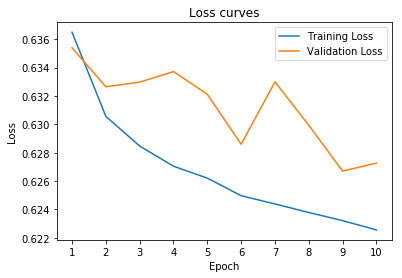

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.xticks(range(10), range(1, 11))

([<matplotlib.axis.XTick at 0x7ee1a0307f98>,
 <a list of 10 Text xticklabel objects>)

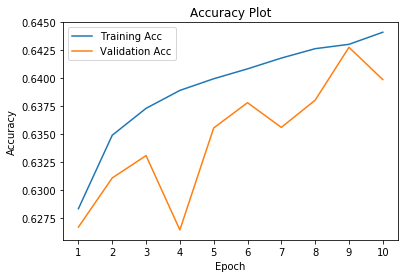

In [9]:
plt.plot(history.history['acc'], label='Training Acc')
plt.plot(history.history['val_acc'], label='Validation Acc')
plt.title("Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.xticks(range(10), range(1, 11))

# Predict Test and Submit to Kaggle

In [12]:
# del df_train
# del X_train, X_val, Y_train, Y_val
x = gc.collect()


from keras.models import load_model
model = load_model('bestNet.h5')

pred = np.zeros((7853253,1))
id = 1
chunksize = 2000000
for df_test in pd.read_csv('../input/test.csv', 
            chunksize = chunksize, usecols=list(dtypes.keys())[0:-1], dtype=dtypes):
    print ('Loaded',len(df_test),'rows of TEST.CSV!')

    cols = []
    for x in FE:
        cols += encode_FE(df_test,x)
    for x in range(len(OHE)):
        cols += encode_OHE_test(df_test,OHE[x],dd[x])

    end = (id)*chunksize
    if end>7853253: end = 7853253
    pred[(id-1)*chunksize:end] = model.predict(df_test[cols])
    print('  encoded and predicted part',id)
    id += 1

Loaded 2000000 rows of TEST.CSV!
  encoded and predicted part 1
Loaded 2000000 rows of TEST.CSV!
  encoded and predicted part 2
Loaded 2000000 rows of TEST.CSV!
  encoded and predicted part 3
Loaded 1853253 rows of TEST.CSV!
  encoded and predicted part 4


In [13]:

df_test = pd.read_csv('../input/test.csv', usecols=['MachineIdentifier'])
df_test['HasDetections'] = pred
df_test.to_csv('submission3.csv', index=False)